In [27]:
import torch
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = 'cpu'

device

device(type='cuda', index=0)

In [28]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def make_generator_network(input_size,
                           num_hidden_layers,
                           num_hidden_units,
                           num_output_units
                          ):
  model = nn.Sequential()
  for i in range(num_hidden_layers):
    model.add_module(f'fc_g{i}', nn.Linear(input_size, num_hidden_units))
    model.add_module(f'relu_g{i}', nn.LeakyReLU())
    input_size = num_hidden_units

  model.add_module(f'fc_g{num_hidden_units}', nn.Linear(input_size, num_output_units))
  model.add_module(f'tanh_g', nn.Tanh())
  return model

def make_discriminator_network(input_size,
                           num_hidden_layers,
                           num_hidden_units,
                           num_output_units
                          ):
  model = nn.Sequential()
  for i in range(num_hidden_layers):
    model.add_module(f'fc_d{i}', nn.Linear(input_size, num_hidden_units))
    model.add_module(f'relu_d{i}', nn.LeakyReLU())
    model.add_module(f'dropout_d{i}', nn.Dropout(p=0.5))
    input_size = num_hidden_units

  model.add_module(f'fc_d{num_hidden_units}', nn.Linear(input_size, num_output_units))
  model.add_module(f'sigmoid_d', nn.Sigmoid())
  return model

In [29]:
image_size = (28, 28)
z_size = 20
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

In [30]:
torch.manual_seed(0)
gen_model = make_generator_network(input_size=z_size,
                                   num_hidden_layers=gen_hidden_layers,
                                   num_hidden_units=gen_hidden_size,
                                   num_output_units=np.prod(image_size)
                                   ).to(device)
print(gen_model)

Sequential(
  (fc_g0): Linear(in_features=20, out_features=100, bias=True)
  (relu_g0): LeakyReLU(negative_slope=0.01)
  (fc_g100): Linear(in_features=100, out_features=784, bias=True)
  (tanh_g): Tanh()
)


In [31]:
disc_model = make_discriminator_network(input_size=np.prod(image_size),
                                        num_hidden_layers=disc_hidden_layers,
                                        num_hidden_units=disc_hidden_size,
                                        num_output_units=1
                                        ).to(device)
print(disc_model)

Sequential(
  (fc_d0): Linear(in_features=784, out_features=100, bias=True)
  (relu_d0): LeakyReLU(negative_slope=0.01)
  (dropout_d0): Dropout(p=0.5, inplace=False)
  (fc_d100): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid_d): Sigmoid()
)


In [32]:
import torchvision
from torchvision import transforms
image_path = './'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])

fashion_mnist_dataset = torchvision.datasets.FashionMNIST(
    root=image_path, train=True,
    transform=transform, download=True
)

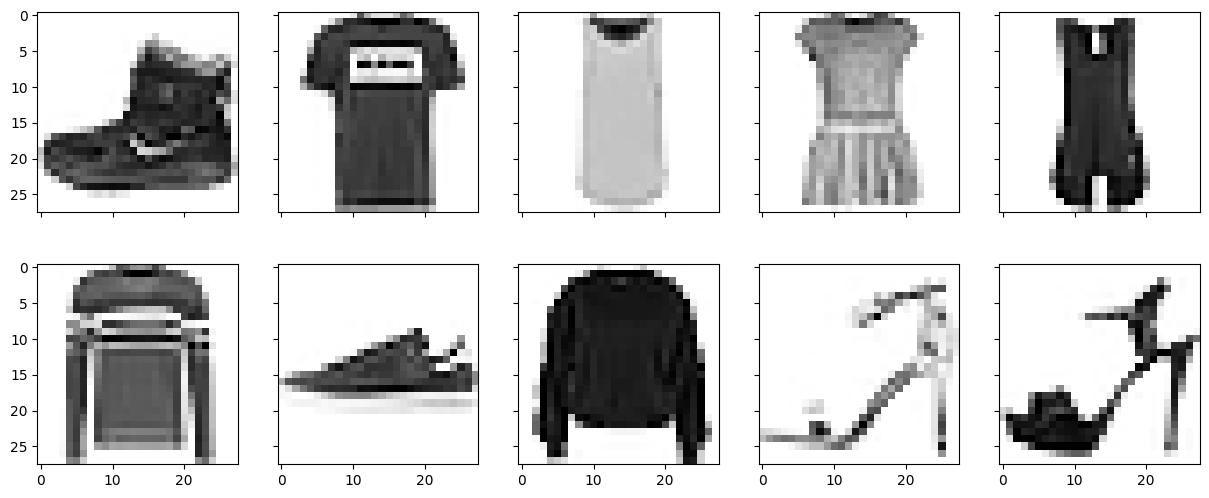

In [33]:
fig, ax = plt.subplots(nrows=2, ncols=5,
                      sharex=True, sharey=True,
                      figsize=(15,6))

ax = ax.flatten()

for i in range(10):
  image = fashion_mnist_dataset[i][0].reshape(*image_size, 1)
  ax[i].imshow((image+1)/2.0, cmap='Grays')

In [34]:
def create_z(batch_size, z_size, mode_z):
  if mode_z == 'uniform':
    input_z = torch.rand(batch_size, z_size)*2 - 1
  elif mode_z == 'normal':
    input_z = torch.randn(batch_size, z_size)
  return input_z

In [35]:
from torch.utils.data import DataLoader
batch_size = 64
fashion_mnist_dl = DataLoader(fashion_mnist_dataset, batch_size,
                        shuffle=True, drop_last=True)

In [36]:
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters(), lr=0.001)
d_optimizer = torch.optim.Adam(disc_model.parameters(), lr=0.001)

In [37]:
def d_train(x):
  disc_model.zero_grad()

  batch_size = x.size(0)
  x = x.view(batch_size, -1).to(device)
  d_labels_real = torch.ones(batch_size, 1, device=device)
  d_prob_real = disc_model(x)
  d_loss_real = loss_fn(d_prob_real,d_labels_real)

  input_z = create_z(batch_size, z_size, mode_z='normal').to(device)
  gen_output = gen_model(input_z)
  d_labels_fake = torch.zeros(batch_size, 1, device=device)
  d_prob_fake = disc_model(gen_output)
  d_loss_fake = loss_fn(d_prob_fake,d_labels_fake)

  d_loss = d_loss_real + d_loss_fake
  d_loss.backward()
  d_optimizer.step()

  return d_loss.data.item(), d_prob_real.detach(), d_prob_fake.detach()

In [38]:
def g_train(x):
  gen_model.zero_grad()

  batch_size = x.size(0)

  input_z = create_z(batch_size, z_size, mode_z='normal').to(device)
  gen_output = gen_model(input_z)
  g_labels_real = torch.ones(batch_size, 1, device=device)
  d_prob_fake = disc_model(gen_output)

  g_loss = loss_fn(d_prob_fake, g_labels_real)
  g_loss.backward()
  g_optimizer.step()

  return g_loss.data.item()

In [39]:
def create_samples(gen_model, input_z):
  batch_size = input_z.size(0)
  gen_output = gen_model(input_z)
  images = torch.reshape(gen_output, (batch_size, *image_size))
  return (images+1)/2.0

In [40]:
epoch_samples = []
all_d_losses = []
all_g_losses = []
all_d_real = []
all_d_fake = []
num_epochs = 100
log = 10

fixed_input_z = create_z(batch_size=5, z_size=z_size,
                         mode_z='normal').to(device)

for epoch in range(1, num_epochs+1):
  d_losses, g_losses = [], []
  d_vals_real, d_vals_fake = [], []
  for i, (x, _) in enumerate(fashion_mnist_dl):
    d_loss, d_prob_real, d_prob_fake = d_train(x)
    g_loss = g_train(x)
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    d_vals_real.append(d_prob_real.mean().cpu())
    d_vals_fake.append(d_prob_fake.mean().cpu())

  all_d_losses.append(torch.tensor(d_losses).mean())
  all_g_losses.append(torch.tensor(g_losses).mean())
  all_d_real.append(torch.tensor(d_vals_real).mean())
  all_d_fake.append(torch.tensor(d_vals_fake).mean())

  if epoch % log == 0:
    print(f'Epoch {epoch}:')
    print(f'  G/D Loss: {all_g_losses[-1]:.4f}/{all_d_losses[-1]:.4f}')
    print(f'  D-Real/D-Fake probs: {all_d_real[-1]:.4f}/{all_d_fake[-1]:.4f}\n')

    epoch_samples.append(
        create_samples(gen_model, fixed_input_z).detach().cpu().numpy()
    )

Epoch 10:
  G/D Loss: 0.8416/1.3024
  D-Real/D-Fake probs: 0.5400/0.4558

Epoch 20:
  G/D Loss: 0.7944/1.3336
  D-Real/D-Fake probs: 0.5268/0.4711

Epoch 30:
  G/D Loss: 0.7419/1.3647
  D-Real/D-Fake probs: 0.5133/0.4874

Epoch 40:
  G/D Loss: 0.7435/1.3597
  D-Real/D-Fake probs: 0.5170/0.4863

Epoch 50:
  G/D Loss: 0.7543/1.3571
  D-Real/D-Fake probs: 0.5160/0.4832

Epoch 60:
  G/D Loss: 0.7395/1.3599
  D-Real/D-Fake probs: 0.5167/0.4869

Epoch 70:
  G/D Loss: 0.7372/1.3666
  D-Real/D-Fake probs: 0.5124/0.4880

Epoch 80:
  G/D Loss: 0.7476/1.3612
  D-Real/D-Fake probs: 0.5130/0.4830

Epoch 90:
  G/D Loss: 0.7708/1.3436
  D-Real/D-Fake probs: 0.5250/0.4782

Epoch 100:
  G/D Loss: 0.7426/1.3607
  D-Real/D-Fake probs: 0.5147/0.4858



Text(0, 0.5, 'Discriminator output')

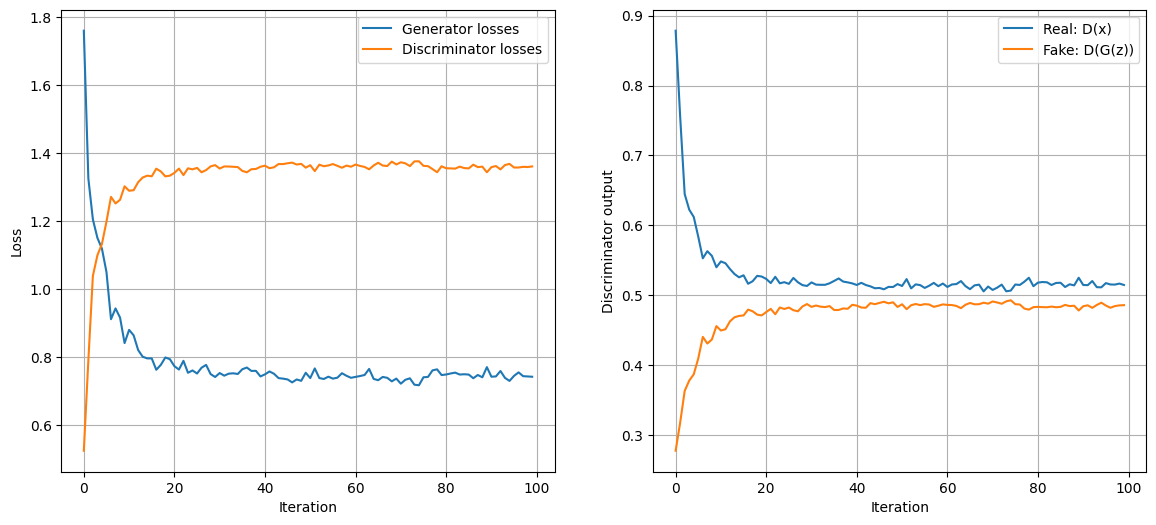

In [44]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)
plt.plot(all_g_losses, label='Generator losses')
plt.plot(all_d_losses, label='Discriminator losses')
plt.legend()
plt.grid()
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')

ax = fig.add_subplot(1, 2, 2)
plt.plot(all_d_real, label='Real: D(x)')
plt.plot(all_d_fake, label='Fake: D(G(z))')
plt.legend()
plt.grid()
ax.set_xlabel('Iteration')
ax.set_ylabel('Discriminator output')

In [46]:
epoch_samples[0].shape

(5, 28, 28)

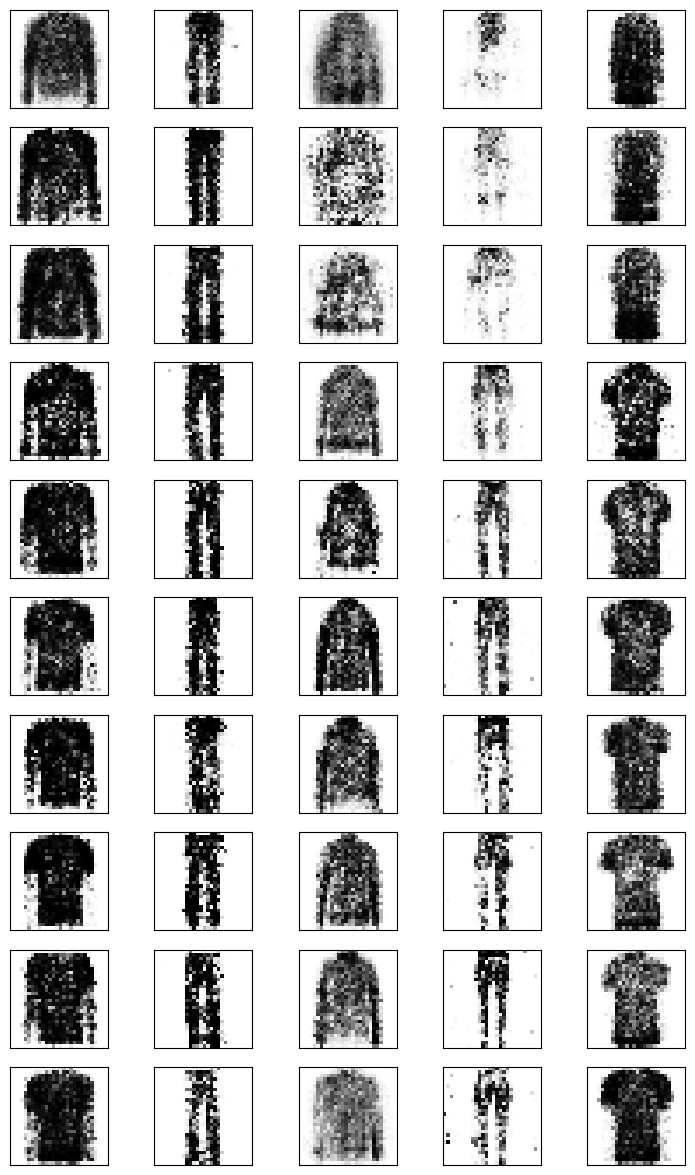

In [54]:
n_stages = num_epochs // log
fig = plt.figure(figsize=(9, 15))
for i in range(n_stages):
  for j in range(5):
    ax = fig.add_subplot(n_stages, 5, i*5+j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    image = epoch_samples[i][j]
    ax.imshow(image, cmap='Grays')